In [1]:
#https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection. Converted class 'yes' 'no' class labels to 0,1.

In [2]:
import sys
import os
import skimage
from skimage import io
from skimage import transform
import numpy as np
import tensorflow as tf
print(tf.__version__)
import keras

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

1.13.0-rc1


Using TensorFlow backend.


In [3]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".JPG")]
        for f in file_names:
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "brain_tumor_dataset/")

In [4]:
X, y = load_data(train_data_directory)

In [5]:
X=np.array(X)
y=np.array(y)
X = [transform.resize(image, (224,224)) for image in X]

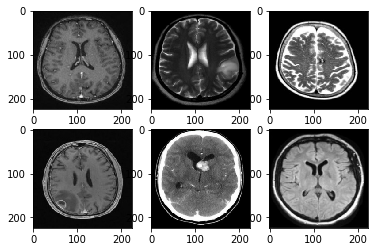

In [6]:
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = np.array(X_train)
X_test=np.array(X_test)
y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

In [10]:
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
NUM_CLASSES = 2

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    model.add(ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',classes=2,))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(NUM_CLASSES))

    model.layers[0].trainable = False


   
    
    return model

In [16]:
from keras import backend as K
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10


# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=Adam(lr=INIT_LR),  # for SGD
)

#Learning rate decay with ReduceLROnPlateau

red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.7)


# fit model

model.fit(
    X_train, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test2),
    callbacks=[red_lr],
    verbose=1,
    shuffle=True
)

Train on 49 samples, validate on 25 samples
Epoch 1/10
49/49 [==============================] - 24s 483ms/sample - loss: 3.7965 - val_loss: 2.2964
Epoch 2/10
49/49 [==============================] - 20s 402ms/sample - loss: 3.4798 - val_loss: 2.1736
Epoch 3/10
49/49 [==============================] - 19s 390ms/sample - loss: 3.9986 - val_loss: 9.1470
Epoch 4/10
49/49 [==============================] - 18s 358ms/sample - loss: 3.7476 - val_loss: 14.1839
Epoch 5/10
32/49 [==================>...........] - ETA: 4s - loss: 1.9607
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0034999999217689036.
49/49 [==============================] - 19s 388ms/sample - loss: 3.9652 - val_loss: 14.1839
Epoch 6/10
49/49 [==============================] - 17s 345ms/sample - loss: 3.0186 - val_loss: 14.1839
Epoch 7/10
49/49 [==============================] - 17s 343ms/sample - loss: 4.6050 - val_loss: 14.1839
Epoch 8/10
32/49 [==================>...........] - ETA: 4s - loss: 2.2668
Epoch 00008:

In [17]:
test_predictions = model.predict_proba(X_test).argmax(axis=-1)

In [18]:
test_answers = y_test2.argmax(axis=-1)

In [19]:
test_accuracy = np.mean(test_predictions==test_answers)


In [20]:
print(test_accuracy*100,'%')


88.0 %
